<a href="https://colab.research.google.com/github/loybenitez/GAN_ODE_Research_project/blob/master/lstm_net.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import scipy.io as sio
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tensorflow import keras
import tensorflow as tf
import random
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM, GRU
import os
random.seed(42)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import pandas as pd

In [ ]:
data_new =  pd.read_csv('/content/drive/My Drive/thecity/logP_lasso.csv',header=0)

#data_new.head()

In [ ]:
y = data_new['logP']


X = data_new.drop(columns=['logP'])
scaler = MinMaxScaler()
scaler.fit(X)
X = scaler.transform(X)


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42, shuffle=False)



In [ ]:
def Add_Window2(dataall, window=1, horizon=1):
        '''
        :param data: shape [B, ...]
        :param window:
        :param horizon:
        :return: X is [B, W, ...], Y is [B, H, ...]
        '''
        length = len(dataall)
        end_index = length - horizon - window + 1
        data = []  # windows
        label = []  # horizon
        idx = 0

        while idx < end_index:
            data.append(dataall[idx:idx + window,1:-1])
            label.append(dataall[idx + window + horizon - 1,0:1])
            idx = idx + 1
        data = np.array(data)
        label = np.array(label)
        return data, label

In [ ]:
df = pd.read_csv('/content/drive/My Drive/thecity/logP_lasso.csv',header=0)
trainnumber = 1 # Dont change
past_datapoints = 1 # Dont change
future_datapoints = 1 # Dont change
batch_size = 5

datafull = np.array(df.iloc[:,0:])
print(datafull.shape)
Xdata = np.array(df.iloc[:,1:]) # selecting X_data after 1st column
Ydata = np.array(df.iloc[:,0:1]) # selecting 1st column as Ydata
print(Xdata.shape)
print(Ydata.shape)

X,y = Add_Window2(np.array(datafull),past_datapoints,future_datapoints)

print('X-shape:', X.shape, 'y-shape:', y.shape)

(141, 20)
(141, 19)
(141, 1)
X-shape: (140, 1, 18) y-shape: (140, 1)


In [ ]:
X = X.reshape(*X.shape[:])
num_output = y.shape[1]
print(num_output)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42, shuffle=False)
print('First value of X:', X[0])
print('First value of y:', y[0])
n_timesteps, n_features, n_outputs = X_train.shape[1], X_train.shape[2], y_train.shape[1]
print('timesteps:', n_timesteps, 'features:', n_features,'Outputs:', n_outputs)

1
First value of X: [[11.212  3.912  0.053  1.865  1.717  2.407  0.5   -0.5   -1.     0.541
  -0.027 18.007  0.241  0.329  2.08   1.003  0.231  0.228]]
First value of y: [4.66]
timesteps: 1 features: 18 Outputs: 1


In [ ]:
#Installing keras_tuner library

!git clone https://github.com/keras-team/keras-tuner.git
!pip install keras_tuner

fatal: destination path 'keras-tuner' already exists and is not an empty directory.


In [ ]:
from kerastuner.tuners import RandomSearch
import warnings
from kerastuner.engine.hyperparameters import HyperParameters
import time
warnings.filterwarnings("ignore")

LOG_DIR = f"{int(time.time())}"

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, BatchNormalization, Activation, Dropout
from tensorflow.keras.layers import Dense

In [ ]:
def build_model(hp):
  model = Sequential()
  model.add(LSTM(hp.Int("input_units",min_value = 24,max_value = 256,step = 12), activation='relu', return_sequences=True, input_shape=(n_timesteps, n_features)))
  model.add(Dropout(hp.Float("Dropout rate:", min_value = 0.1, max_value = 0.5, step = 0.1)))
  model.add(LSTM(hp.Int("hidden_units",min_value = 24, max_value = 256, step = 12), activation='relu'))

  for i in range(hp.Int("n_layers",1,4)):
    model.add(Dense(hp.Int(f"dense_{i}_units",min_value = 24, max_value = 256,step = 12)))
              
  model.add(Dense(n_outputs))
  model.compile(optimizer = 'adam',
                loss = 'mse')
  return model


tuner = RandomSearch(build_model,
                     objective = 'val_loss',
                     max_trials = 5,
                     executions_per_trial = 2,
                     directory = LOG_DIR)

tuner.search(x = X, y = y,
             epochs = 100,
             batch_size = 5,
             validation_data=(X_test,y_test))

print(tuner.get_best_hyperparameters()[0].values)
print(tuner.results_summary())
print(tuner.get_best_models()[0].summary())




Trial 5 Complete [00h 00m 38s]
val_loss: 0.062433596700429916

Best val_loss So Far: 0.062433596700429916
Total elapsed time: 00h 03m 09s
INFO:tensorflow:Oracle triggered exit
{'input_units': 84, 'Dropout rate:': 0.2, 'hidden_units': 96, 'n_layers': 4, 'dense_0_units': 240, 'dense_1_units': 156, 'dense_2_units': 192, 'dense_3_units': 216}
Results summary
Results in 1633060574/untitled_project
Showing 10 best trials
Objective(name='val_loss', direction='min')
Trial summary
Hyperparameters:
input_units: 84
Dropout rate:: 0.2
hidden_units: 96
n_layers: 4
dense_0_units: 240
dense_1_units: 156
dense_2_units: 192
dense_3_units: 216
Score: 0.062433596700429916
Trial summary
Hyperparameters:
input_units: 168
Dropout rate:: 0.30000000000000004
hidden_units: 144
n_layers: 4
dense_0_units: 108
dense_1_units: 204
dense_2_units: 72
dense_3_units: 24
Score: 0.06321414187550545
Trial summary
Hyperparameters:
input_units: 228
Dropout rate:: 0.4
hidden_units: 84
n_layers: 3
dense_0_units: 108
dense_1_u

In [ ]:
model = tuner.get_best_models()[0]

In [ ]:
from keras.callbacks import EarlyStopping, ModelCheckpoint
filepath = '/content/drive/My Drive/thecity/.model'
Train = trainnumber
if Train == 1:  # First training
    es = EarlyStopping(monitor='val_loss', mode=min, patience=150, verbose=1)
    checkpoint = ModelCheckpoint(filepath,monitor='val_loss', verbose=1, save_best_only=True, mode='min')
    model.fit(X_train, y_train, batch_size=batch_size, epochs=1000, verbose=2, validation_split=0.3,callbacks=[es,checkpoint])
    
    model.save("/content/drive/My Drive/thecity/LSTM_tuned_by_jorge.hdf5")
elif Train == 0:  # Zero-shot transfer learning
    model.save_weights("./model/QSAR_LSTM.h5")


Epoch 1/1000
16/16 - 3s - loss: 0.1001 - val_loss: 0.1349

Epoch 00001: val_loss improved from inf to 0.13494, saving model to /content/drive/My Drive/thecity/.model
INFO:tensorflow:Assets written to: /content/drive/My Drive/thecity/.model/assets
Epoch 2/1000
16/16 - 0s - loss: 0.0935 - val_loss: 0.2165

Epoch 00002: val_loss did not improve from 0.13494
Epoch 3/1000
16/16 - 0s - loss: 0.0706 - val_loss: 0.3900

Epoch 00003: val_loss did not improve from 0.13494
Epoch 4/1000
16/16 - 0s - loss: 0.0874 - val_loss: 0.1353

Epoch 00004: val_loss did not improve from 0.13494
Epoch 5/1000
16/16 - 0s - loss: 0.1286 - val_loss: 0.3779

Epoch 00005: val_loss did not improve from 0.13494
Epoch 6/1000
16/16 - 0s - loss: 0.1052 - val_loss: 0.0989

Epoch 00006: val_loss improved from 0.13494 to 0.09886, saving model to /content/drive/My Drive/thecity/.model
INFO:tensorflow:Assets written to: /content/drive/My Drive/thecity/.model/assets
Epoch 7/1000
16/16 - 0s - loss: 0.1276 - val_loss: 0.4362

Epo

In [ ]:
from keras.models import load_model
tuned_model = load_model("/content/drive/My Drive/thecity/LSTM_tuned_by_jorge.hdf5")



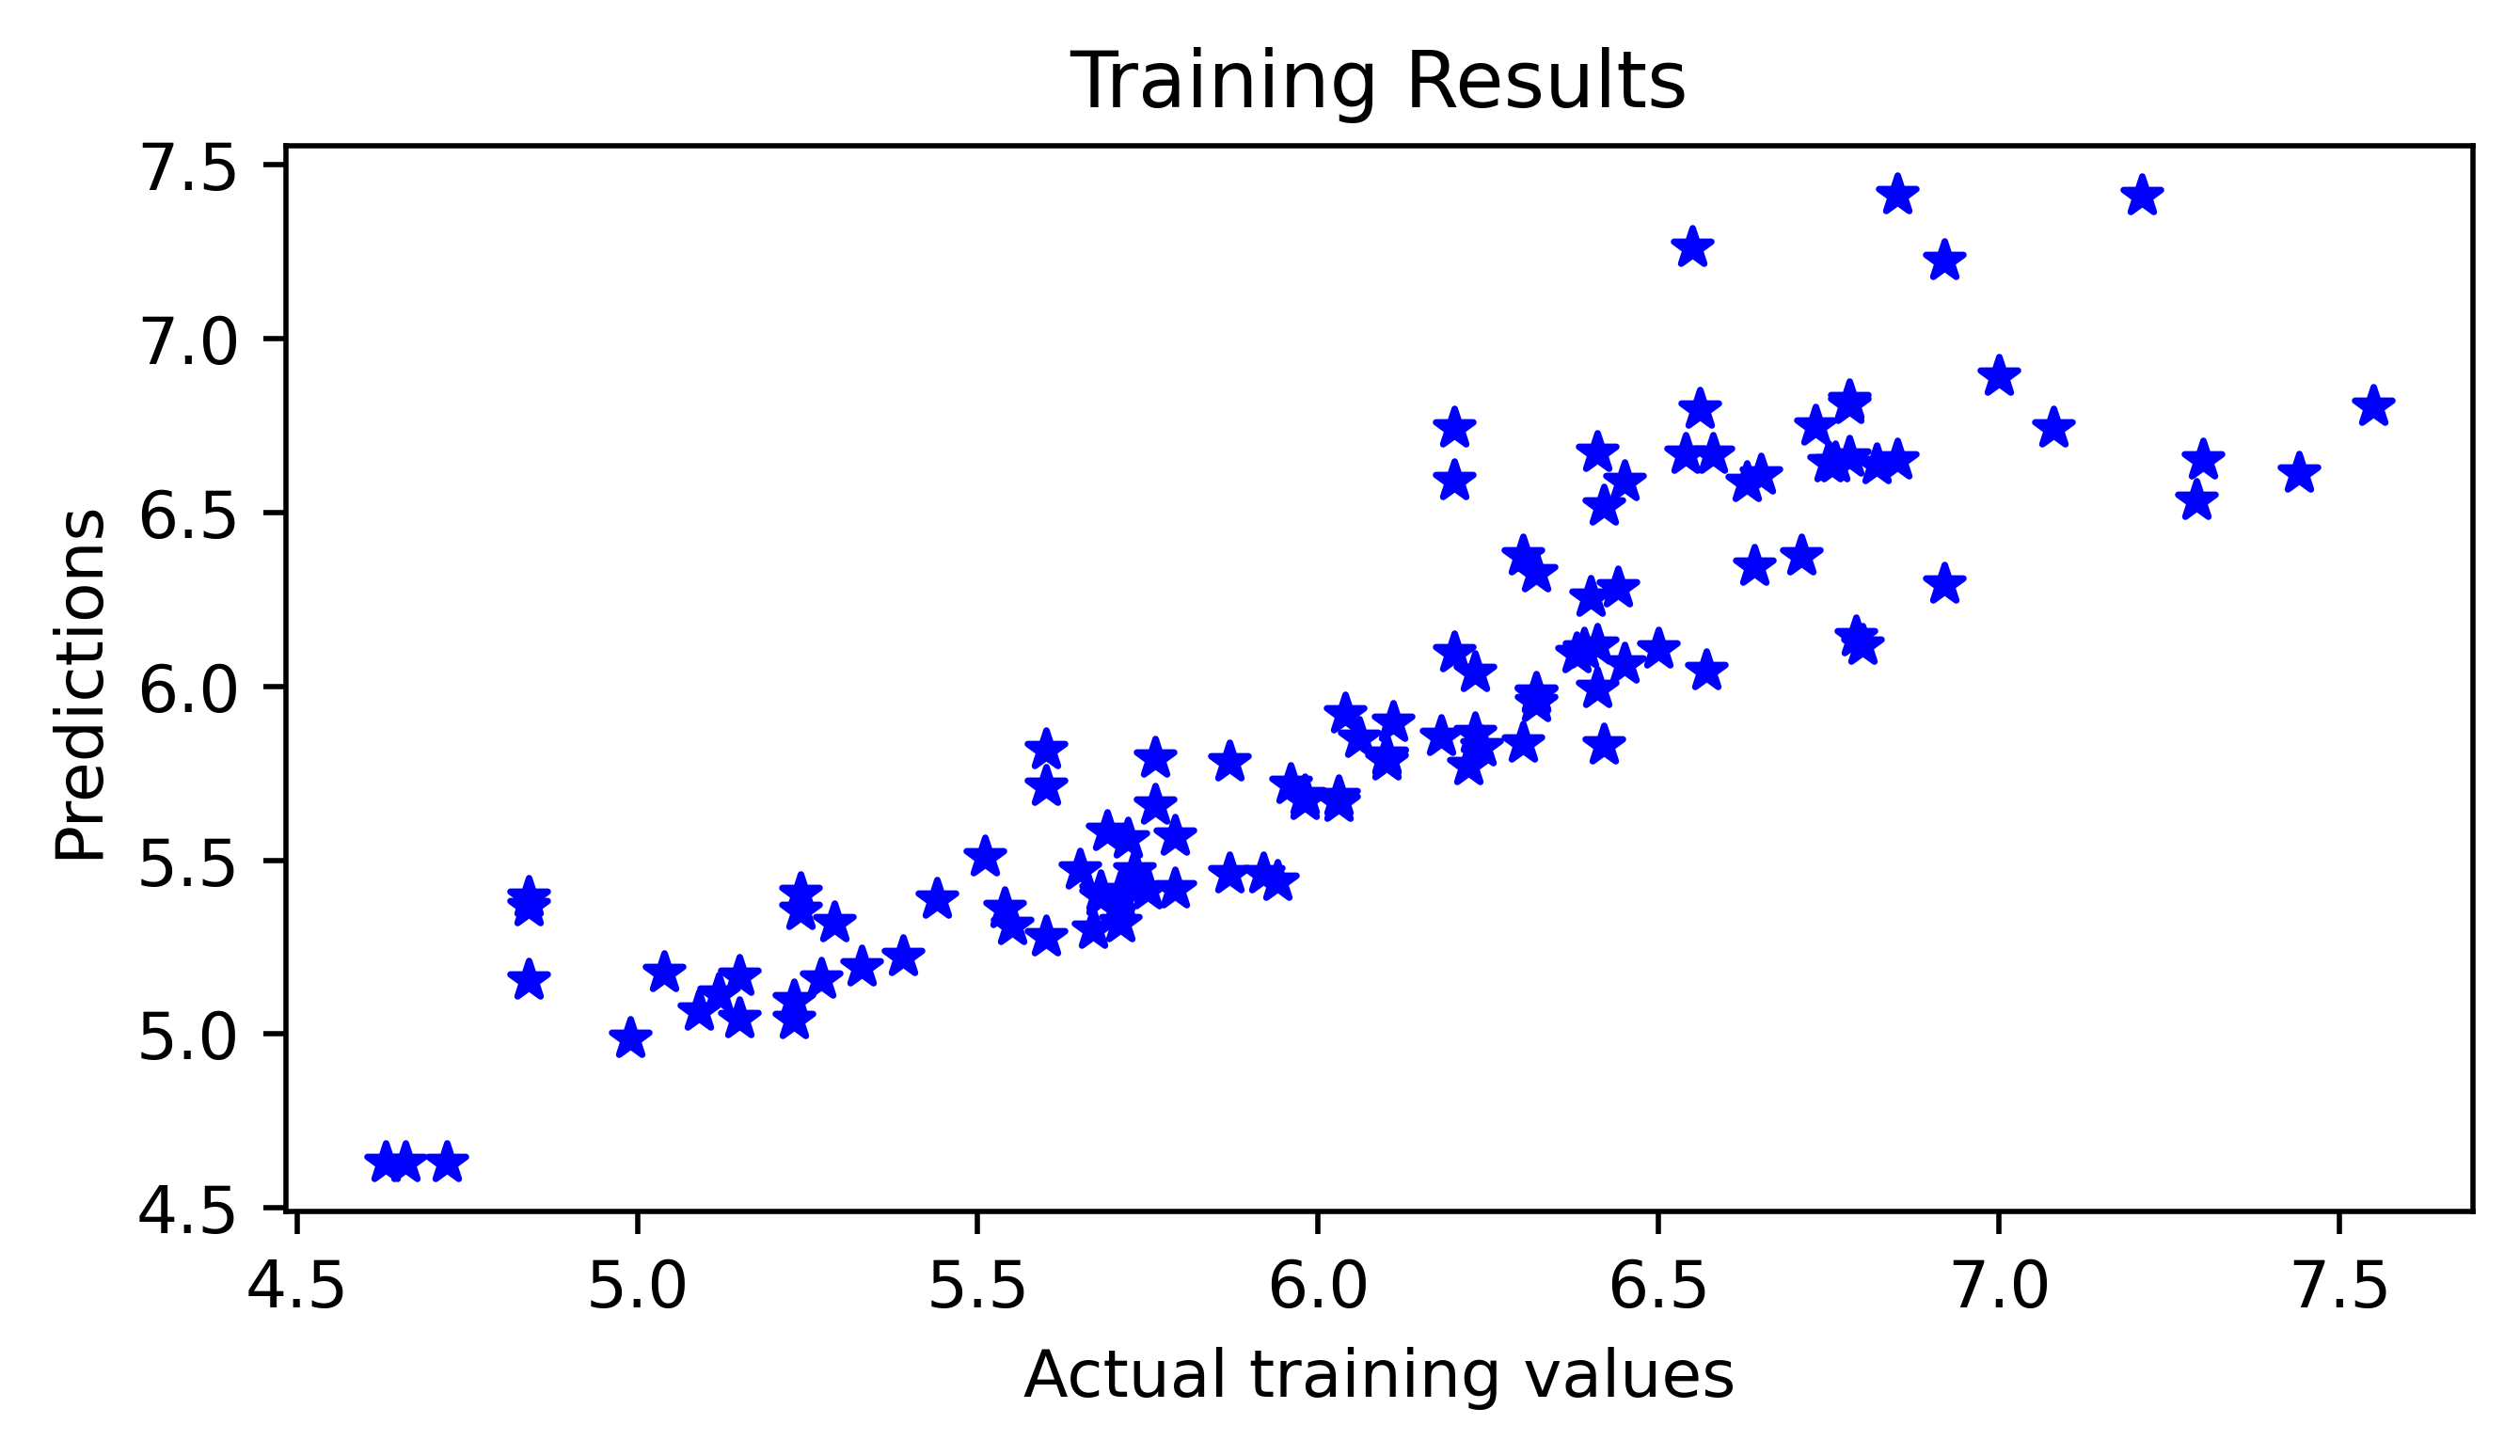

In [ ]:
import matplotlib.pyplot as plt

pred_train = tuned_model.predict(X_train)

plt.figure(figsize=(6,3),dpi = 500)
plt.scatter(y_train,pred_train, color = 'b', marker = '*')
plt.title('Training Results')
plt.xlabel('Actual training values')
plt.ylabel('Predictions')
plt.show()


In [ ]:
pred_test = tuned_model.predict(X_test)

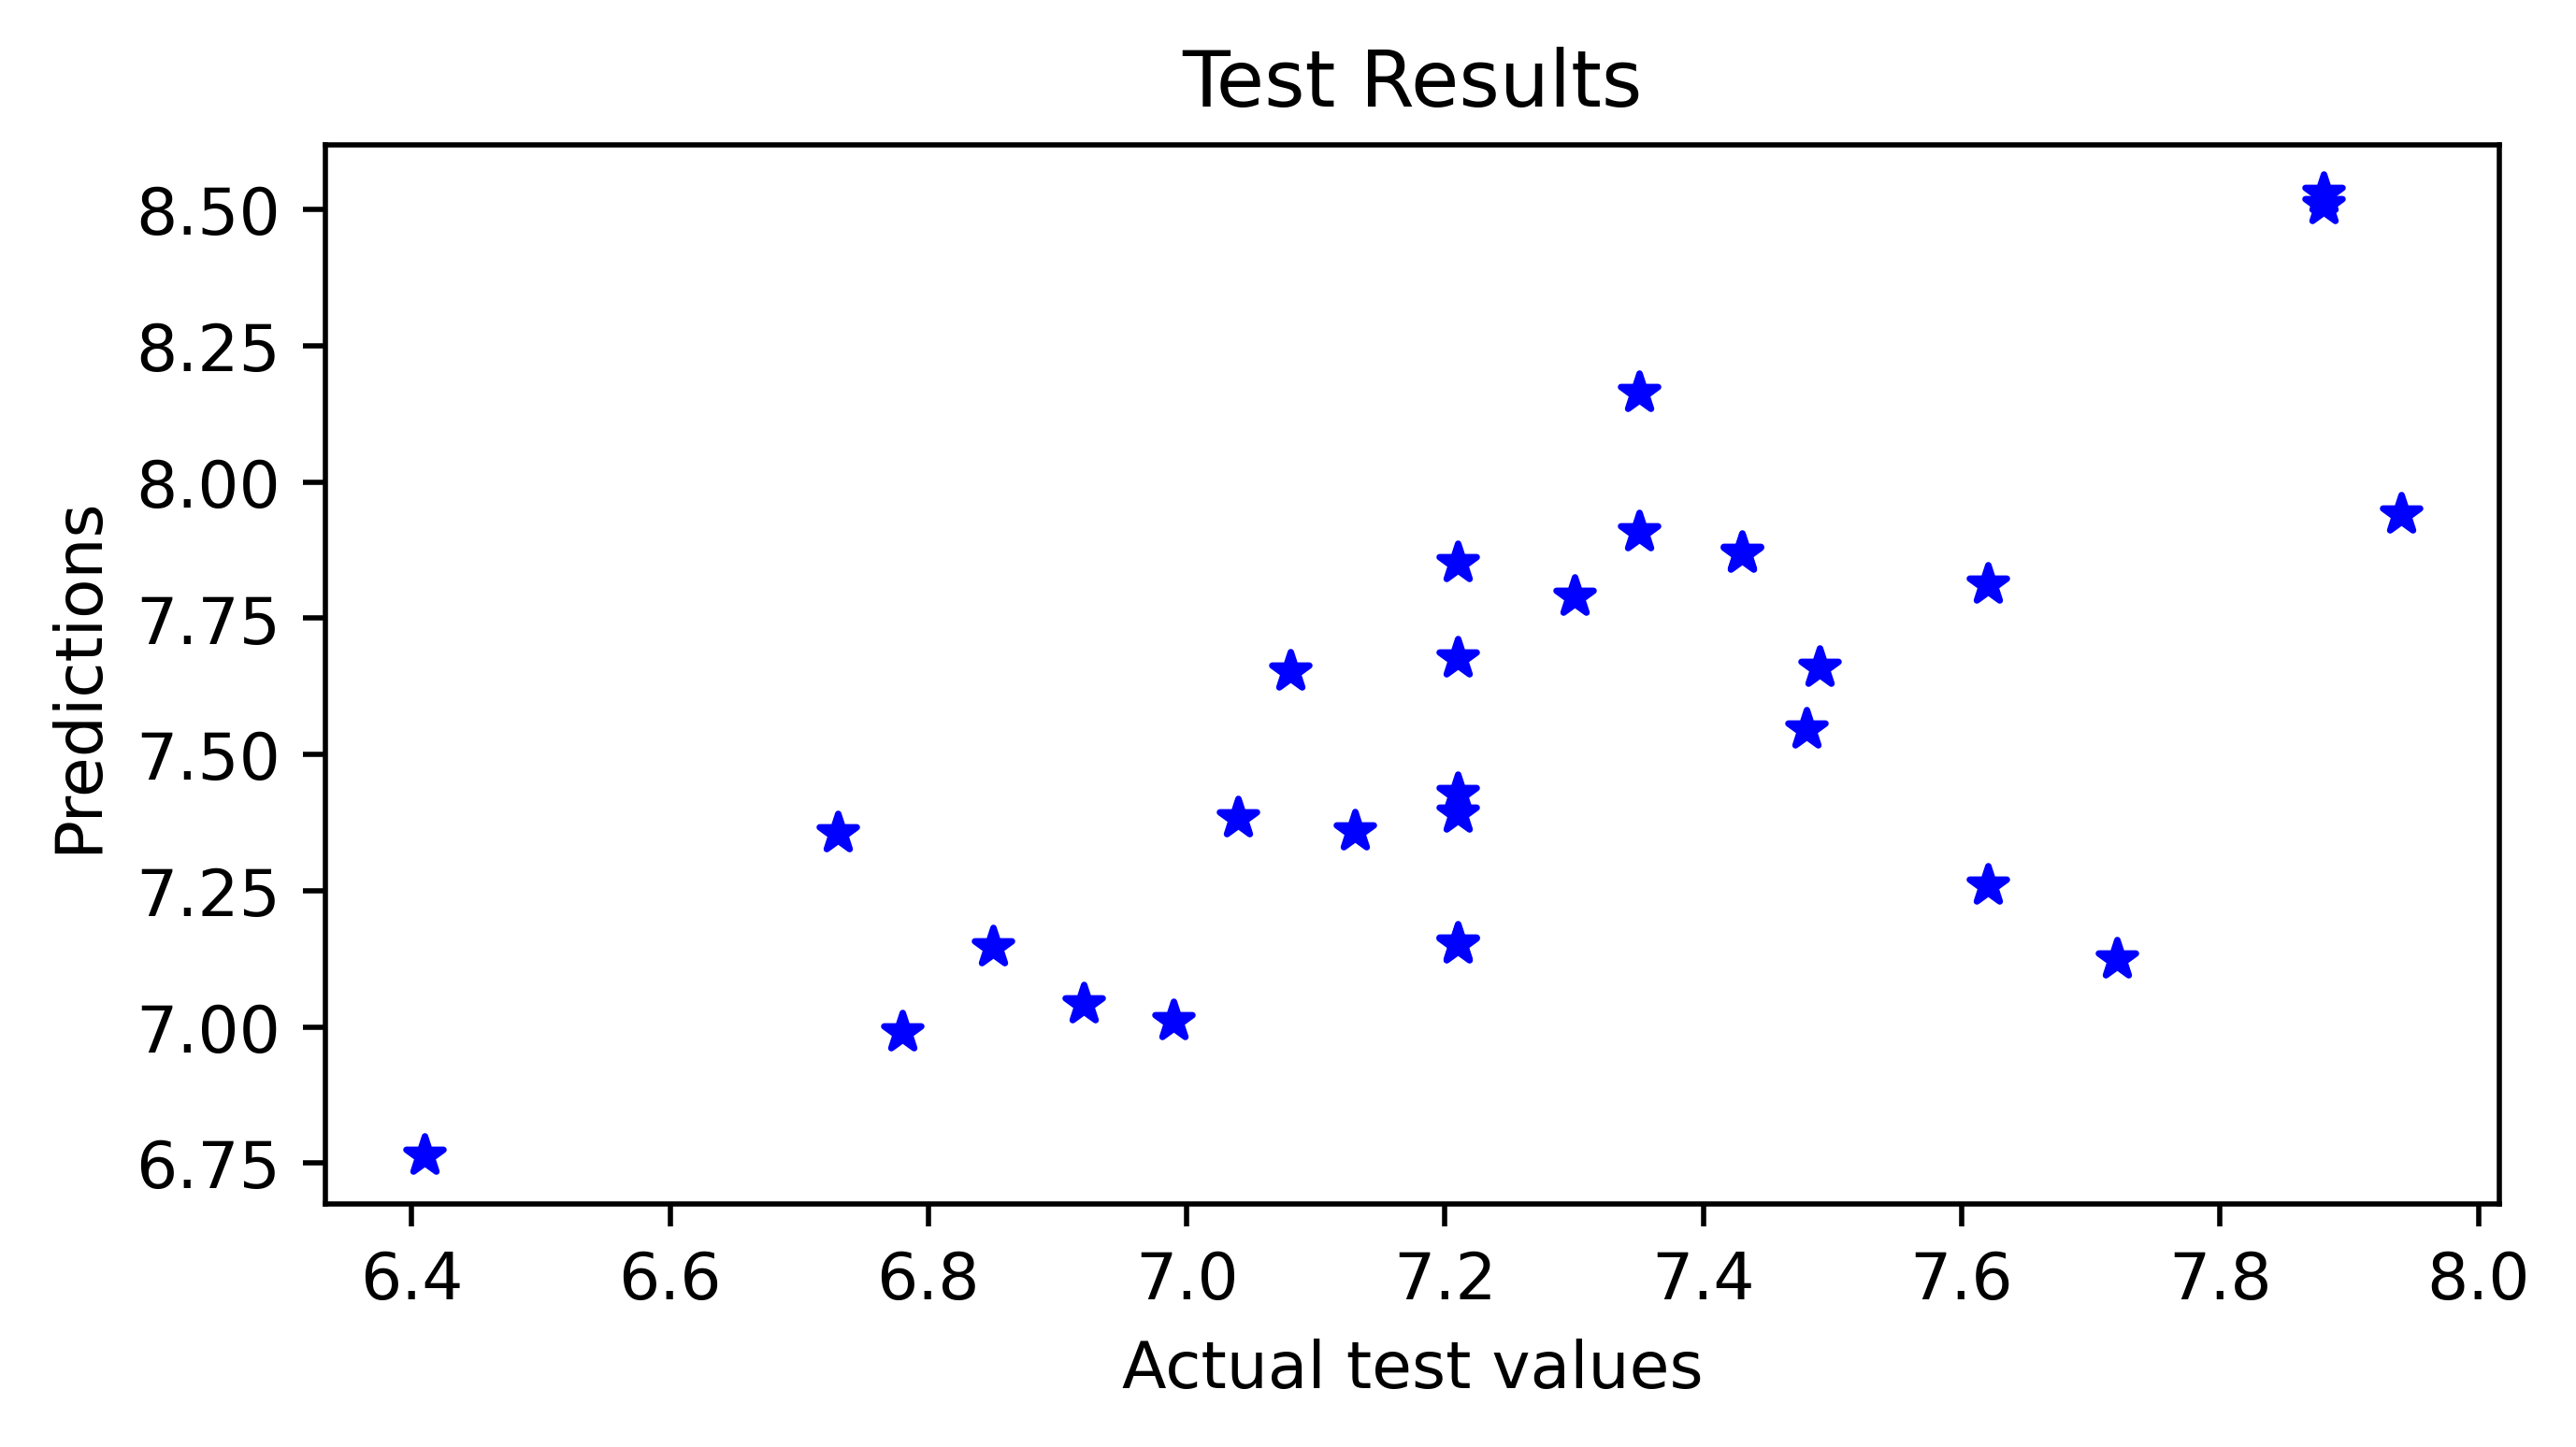

In [ ]:

plt.figure(figsize=(6,3),dpi = 500)
plt.scatter(y_test,pred_test, color = 'b', marker = '*')
plt.title('Test Results')
plt.xlabel('Actual test values')
plt.ylabel('Predictions')
plt.show()

In [ ]:


y_true = np.concatenate((y_train,y_test),axis=0)
y_pred = np.concatenate((pred_train,pred_test),axis=0)

r2 = 1 - ((y_true - y_pred)**2).sum() / ((y_true - y_true.mean())**2).sum()
print('r2 score = {:.3f}'.format(r2))

mse = ((y_true - y_pred)**2).mean()
rmse = np.sqrt(mse)
print('mse = {:.3f}\nrmse = {:.3f}'.format(mse, rmse))

mae = (np.abs(y_true - y_pred)).mean()
print('mae = {:.3f}'.format(mae))

press = ((y_true - y_pred)**2).sum()
print('PRESS = {:.3f}'.format(press))

r2 score = 0.799
mse = 0.120
rmse = 0.346
mae = 0.282
PRESS = 16.763


In [ ]:
import scipy.io as sio

sio.savemat("/content/drive/My Drive/thecity/matlab_outputs/LSTM__train_logP_elastic_tuned.mat", {"LSTM_y_train": y_train})
sio.savemat("/content/drive/My Drive/thecity/matlab_outputs/LSTM_pred_train_logP_elastic_tuned.mat", {"LSTM_pred_train": pred_train})
sio.savemat("/content/drive/My Drive/thecity/matlab_outputs/LSTM_test_logP_elastic_tuned.mat", {"LSTM_ytest": y_test})
sio.savemat("/content/drive/My Drive/thecity/matlab_outputs/LSTM_pred_logP_elastic_tuned.mat", {"LSTM_ypred": pred_test})